In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms, datasets
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os,json

In [14]:
### 이미지 그레이스케일로 가져와서 오츠 알고리즘 돌리기
## TrainData 
train_json_path = './dataset/train/train_defected_json'
train_img_path = './dataset/train/train_defected_dataset'

# make dir
if not os.path.isdir('./dataset/train/train'):
    os.makedirs('./dataset/train/train/st')
    os.makedirs('./dataset/train/train/aq')
    os.makedirs('./dataset/train/train/fl')

for idx in os.listdir(train_json_path):
    # json files load
    with open(f'{train_json_path}/{idx}', 'r') as f:
        json_dict = json.load(f)
    
    # read image
    img = cv2.imread(f'{train_img_path}/{json_dict["image_name"]}', cv2.IMREAD_GRAYSCALE)

    # save image
    cv2.imwrite(f'./dataset/train/train/{json_dict["defect_class"]}/{json_dict["image_name"]}',img)

In [15]:
# GradCAM 클래스 정의
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # 타겟 레이어에서 기울기 값을 얻기 위해 Hook 설정
        self.hook_layer()

    # Forward 및 Backward에서 Hook을 설정하는 함수
    def hook_layer(self):
        # Forward 시 활성화 값 저장
        def forward_hook(module, input, output):
            self.activation = output
        
        # Backward 시 기울기 값 저장
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        # Forward 및 Backward에서 Hook 등록
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    # 모델에 입력 데이터를 전달하는 함수
    def forward(self, x):
        return self.model(x)

    # GradCAM 결과를 생성하는 함수
    def generate_cam(self, input_image, target_class):
        # 기울기 계산을 위해 모델의 기울기를 0으로 초기화
        self.model.zero_grad()
        output = self.forward(input_image)

        # 타겟 클래스에 대한 점수 추출
        target = output[:, target_class]
        target.backward()  # 역전파 수행

        # 기울기의 평균 계산
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # 기울기를 기반으로 활성화 맵에 가중치 적용
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        # 채널별로 평균을 내어 최종 CAM 생성
        cam = torch.mean(self.activation, dim=1).squeeze()

        # 음수 값을 제거하기 위해 ReLU 적용
        cam = torch.clamp(cam, min=0)

        # CAM을 0과 1 사이의 값으로 정규화
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam.detach().cpu().numpy()

In [16]:
# 이미지 전처리 및 데이터셋 로드
def load_data(train_dir, batch_size=32, valid_ratio=0.2):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),  # 입력 이미지 크기를 512x512로 맞춤
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 데이터셋 로드
    dataset = datasets.ImageFolder(root=train_dir, transform=transform)

    # 데이터셋을 학습과 검증 세트로 분할
    total_size = len(dataset)
    valid_size = int(total_size * valid_ratio)
    train_size = total_size - valid_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

    # 데이터 로더 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

# 모델 학습 함수
def train_model(model, train_loader, valid_loader, epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # GPU 사용 가능 시 GPU로 이동
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # 학습 단계
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # 검증 단계
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, '
              f'Validation Loss: {val_loss / len(valid_loader):.4f}, Accuracy: {correct / total:.4f}')

    print('Finished Training')

In [17]:
# 이미지 전처리 함수
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),  # 입력 이미지 크기를 512x512로 조정
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 표준화 적용
    ])
    # 이미지 읽기
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
    input_tensor = preprocess(image).unsqueeze(0)  # 배치 차원을 추가
    return image, input_tensor

# GradCAM 결과를 시각화하는 함수
def show_cam_on_image(image, mask):
    # CAM 마스크를 컬러맵으로 변환
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255  # 정규화
    cam = heatmap + np.float32(image) / 255  # 원본 이미지와 합성
    cam = cam / np.max(cam)  # 값을 0~1 사이로 정규화
    return np.uint8(255 * cam)  # 다시 255 범위로 변환

In [ ]:
# 학습할 데이터 경로와 이미지 경로 및 타겟 클래스를 지정하고 GradCAM 실행
train_dir = './dataset/train/train/'  # 학습 데이터 경로
image_path = './dataset/validation/validation_defected_dataset/seaweed_01348.png'  # GradCAM 적용할 이미지 경로
target_class = 1  # 이물질 종류 클래스 (예: 0 - 이물질 없음, 1 - 이물질 종류 1, 2 - 이물질 종류 2)
epochs = 10

# ResNet18 모델을 랜덤 가중치로 초기화
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 3)  # 이물질 분류를 위한 3개 클래스

# 학습 및 검증 데이터 로드
train_loader, valid_loader = load_data(train_dir)

# 모델 학습
train_model(model, train_loader, valid_loader, epochs=epochs)

# 타겟 레이어는 마지막 합성곱 층
target_layer = model.layer4[1].conv2

# GradCAM 초기화
grad_cam = GradCAM(model, target_layer)

# 이미지 전처리 (GradCAM을 적용할 이미지)
raw_image, input_tensor = preprocess_image(image_path)

# GradCAM 생성
cam_mask = grad_cam.generate_cam(input_tensor, target_class)

# CAM 마스크를 원본 이미지 크기로 리사이즈
cam_mask = cv2.resize(cam_mask, (raw_image.shape[1], raw_image.shape[0]))

# 원본 이미지 위에 CAM 시각화
cam_image = show_cam_on_image(raw_image, cam_mask)

# 결과 출력
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(raw_image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title('GradCAM')
plt.show()

c:\Users\Woohyeop\AppData\Local\anaconda3\envs\AIDATA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Woohyeop/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%
c:\Users\Woohyeop\AppData\Local\anaconda3\envs\AIDATA\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(ar

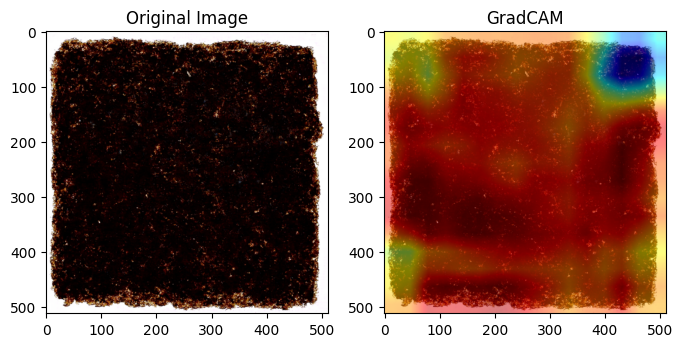

In [11]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# GradCAM 클래스 정의
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook the target layer to get gradients
        self.hook_layer()

    def hook_layer(self):
        def forward_hook(module, input, output):
            self.activation = output
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        # Forward and backward hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def forward(self, x):
        return self.model(x)

    def generate_cam(self, input_image, target_class):
        self.model.zero_grad()
        output = self.forward(input_image)

        # Extract the score for the target class
        target = output[:, target_class]
        target.backward()

        # Get pooled gradients
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # Weight the activations with the pooled gradients
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        # Average the activations across the channels
        cam = torch.mean(self.activation, dim=1).squeeze()

        # Apply ReLU to remove negative values
        cam = torch.clamp(cam, min=0)

        # Normalize the CAM to a range between 0 and 1
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam.detach().cpu().numpy()

# Image Preprocessing
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),  # 입력 이미지 크기 512x512
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_tensor = preprocess(image).unsqueeze(0)  # 배치 차원 추가
    return image, input_tensor

# GradCAM 시각화 함수
def show_cam_on_image(image, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image) / 255
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# 모델 로드 및 GradCAM 적용
def main(image_path, target_class):
    # 다중 클래스 분류를 위한 ResNet18 모델 로드 (사전 학습된 모델 사용)
    model = models.resnet18(pretrained=True)
    
    # 마지막 레이어를 이물질 분류에 맞게 수정
    model.fc = nn.Linear(model.fc.in_features, 3)  # 3개의 클래스로 (예: 이물질 없음, 이물질 종류 1, 이물질 종류 2)
    model.eval()

    # Target layer는 마지막 합성곱 층을 사용 (layer4의 두 번째 블록)
    target_layer = model.layer4[1].conv2

    # GradCAM 초기화
    grad_cam = GradCAM(model, target_layer)

    # 이미지 전처리
    raw_image, input_tensor = preprocess_image(image_path)

    # GradCAM 적용
    cam_mask = grad_cam.generate_cam(input_tensor, target_class)

    # CAM 마스크를 원본 이미지 크기에 맞게 리사이즈
    cam_mask = cv2.resize(cam_mask, (raw_image.shape[1], raw_image.shape[0]))

    # CAM을 입력 이미지 위에 겹쳐서 시각화
    cam_image = show_cam_on_image(raw_image, cam_mask)

    # 결과 출력
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(raw_image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title('GradCAM')
    plt.show()

# 이미지 경로와 타겟 클래스를 지정하고 GradCAM 실행
image_path = './dataset/validation/validation_defected_dataset/seaweed_01348.png'  # 분석할 이미지 경로
target_class = 1  # 예: 0 - 이물질 없음, 1 - 이물질 종류 1, 2 - 이물질 종류 2

if __name__ == "__main__":
    main(image_path, target_class)
